# BitTiger DS501 Week10

1. [Feedforward Neural Network](#Feedforward-Neural-Network)
2. LSTM
   * [Text generation](#Text-generation)
   * [Twiter](#Twiter)
3. [CNN](CNN)
4. Tensorflow
   * [Devise](#Devise)
   * [Linear regression](#Linear-regression)
   * [Tensorboard](#Tensorboard)

## Feedforward Neural Network

* **FFNN**

In [36]:
from __future__ import print_function # Must be the first line

import keras.callbacks as cb
from keras.datasets import mnist
from keras.layers.core import Activation, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import SGD
from keras.regularizers import l1, l2
from keras.utils import np_utils

import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Pre-processing

### 分成 3 個 Groups:
1. A: 沒有 pre-processing
2. B: 用 normalization 把 dataset normalize 到 [0, 1] 之間
\begin{equation}x' = \frac{x - x_{min}}{x_{max} - x_{min}}\end{equation}
3. C: 用 standardization 把 dataset 變成 mean=0, variance=1 的高斯分佈
\begin{equation}x_i' = \frac{x_i - \mu}{\sigma}\end{equation}

通常知道數據的最大值和最小值的時候，就使用 normalization，如果不知道最大值和最小值，就使用 standardization

In [37]:
def Preprocessing(group):
    from sklearn import preprocessing
    # Load MNIST dataset from Keras (https://keras.io/datasets/)
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    
    # Transform labels to one-hot
    y_train = np_utils.to_categorical(y_train, 10)
    y_test = np_utils.to_categorical(y_test, 10)
    
    # Set features to numeric type
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    # Reshape from 28 x 28 to 1-D vector
    # 28 x 28 = 784
    X_train = np.reshape(X_train, (60000, 784))
    X_test = np.reshape(X_test, (10000, 784))
    
    if group == 'A':
        return X_train, X_test, y_train, y_test
    elif group == 'B':
        X_train /= 255
        X_test /= 255
    elif group == 'C':
        X_train = preprocessing.scale(X_train)
        X_test = preprocessing.scale(X_test)
        
    return X_train, X_test, y_train, y_test

In [38]:
group = 'B'
X_train, X_test, y_train, y_test = Preprocessing(group)

### 檢查一下 training data

只看前 10 筆資料

In [39]:
print('{:^44}'.format('X'), '|', '{:^4}'.format('y'))
print('='*50)
for row in range(10):
    print('{:.2f} {:.2f} ... {:.2f} {:.2f} {:.2f}  ... {:.2f} {:.2f} '.format(
            X_train[row][0], X_train[row][1],
            X_train[row][156], X_train[row][157], X_train[row][158],
            X_train[row][-2], X_train[row][-1]), '| ',
            '{:.0f}'.format(y_train[row][0])
         )

                     X                       |  y  
0.00 0.00 ... 0.49 0.53 0.69  ... 0.00 0.00  |  0
0.00 0.00 ... 0.99 0.99 0.99  ... 0.00 0.00  |  1
0.00 0.00 ... 0.00 0.00 0.00  ... 0.00 0.00  |  0
0.00 0.00 ... 0.00 0.00 0.49  ... 0.00 0.00  |  0
0.00 0.00 ... 0.00 0.00 0.00  ... 0.00 0.00  |  0
0.00 0.00 ... 0.10 0.39 0.48  ... 0.00 0.00  |  0
0.00 0.00 ... 0.00 0.00 0.00  ... 0.00 0.00  |  0
0.00 0.00 ... 0.99 0.99 0.99  ... 0.00 0.00  |  0
0.00 0.00 ... 0.00 0.00 0.00  ... 0.00 0.00  |  0
0.00 0.00 ... 0.00 0.00 0.00  ... 0.00 0.00  |  0


## 2. Define model

### Network Structure

經驗上：寬度 < 1000 個 neurons，深度 10 ~ 30 層，形狀用金字塔型

深度可以用 sample/parameter raton 來估計，約 5 ~ 30
* 通常 10 ~ 30 層
* 目前最深 150 層


1. A: 1 layer
2. B: 2 layers, tower-shaped (一樣寬)
3. C: 2 layers, pyramid-shaped (越來越窄)

In [40]:
def layers(group):
    if group == 'A':
        first_layer_width = 128
        second_layer_width = 0
    elif group == 'B':
        first_layer_width = 128
        second_layer_width = 128
    elif group == 'C':
        first_layer_width = 128
        second_layer_width = 64
        
    return first_layer_width, second_layer_width

### Activation Function
1. ReLU
2. Sigmoid
3. Tanh

![activation_function](https://ujwlkarn.files.wordpress.com/2016/08/screen-shot-2016-08-08-at-11-53-41-am.png)

Sigmoid($x$) 和 $\tanh(x)$ 在 $x$ 很大或很小時 (就是在兩端時)，會有 **vanishing gradient** 的問題

ReLU($x$) 在 $x > 0$ 時不會有 vanishing gradient 的問題 

In [41]:
# activation_func = 'relu'
# activation_func = 'sigmoid'
# activation_func = 'tanh'

In [42]:
def activation_function(func):
    if func == 'relu':
        return 'relu'
    elif func == 'sigmoid':
        return 'sigmoid'
    elif func == 'tanh':
        return 'tanh'
    else:
        return func

### Loss Function

Loss function 又叫做 cost function，就是 prediction 和 ground truth 之間的差別。

算 loss 時要算的是 total loss $L = \sum_{i=1}^{R} \ell_i$，然後要把 total loss minimize

常用的 loss function 有兩種:
1. Cross entropy: 適合 categorical 的數據
   \begin{equation} -\sum_{i=1}^{k} (y_{i} \log\hat{y}_{i})\end{equation}
2. Squared error (MSE): 適合 continuous 的數據
   \begin{equation}\sum_{i=1}^{k}(y_{i} - \hat{y}_{i})^{2}\end{equation}

In [43]:
def loss_func(loss):
    if loss == 'crossentropy':
        return 'categorical_crossentropy'
    elif loss == 'MSE':
        return 'mean_squared_error'

### Dropout rate
可以輸入想要的 dropout rate，例如 0%, 50%, 90% 等

* dropout rate < 0.5
  * 通常是 0.1 ~ 0.3
* 每一層都有一個 dropout rate，在 training 前就要定義好，因為 dropout rate 是 hyperparameter
* Training 才要 dropout，**testing 不 dropout**
  * Training 每一層關掉 p% 的神經元
  * Testing 的 weight $\times (1-p\%)$

In [44]:
def set_dropout_rate(num):
    if num > 1:
        print('Dropout rate is between 0 and 1')
        return
    else:
        return num

### Regularization

目標是 minimize $\Big(\sum_{i=1}^{R} L(y_i, \hat{y}_i) + R(w) \Big)$

1. No regularization: no
2. L1-norm: l1
   \begin{equation}R(w, \lambda) = \lambda ||w||_{1} = \lambda \sum_{i}|w|_{i} = \lambda(|w_1| + |w_2| + \cdots + |w_k|)\end{equation}
3. L2-norm: l2
   \begin{equation}R(w, \lambda) = \lambda ||w||_{2} = \lambda \sqrt{\sum_{i} w_{i}^{2}} = \lambda \sqrt{w_1^2 + w_2^2 + \cdots + w_k^2}\end{equation}
   
還有一個是 max-norm，這是一個 post-processing 的過程，不會在 optimization 時發生。每一個 weight 更新之後，就再除以自己的 norm，再乘上 $\lambda$ 使得新的 weight 一定小於 $\lambda$，這樣子 weight 就不會爆掉。
* $||w||_2 < \lambda$，$\lambda$ 的值大概是 $3 \sim 4$

In [45]:
def regularization(regularization = None):
    if regularization == 'l1':
        return 'l1'
    elif regularization == 'l2':
        return 'l2'
    else:
        return regularization

### Mini-batch size
可以設定 mini-batch 的大小，例如 128, 256, 512 等

通常是 4 的倍數，這和硬體 cache 的設計有關 

In [46]:
def mini_batch_size(size):
    if size == 128:
        return 128
    elif size == 256:
        return 256
    elif size == 512:
        return 512
    else:
        return size

### Learning Rate

可以設定 learning rate 的大小，例如 0.1, 0.01, 0.5 等

\begin{equation}w' \leftarrow w - \eta \cdot \frac{\partial L}{\partial w}\end{equation}

learning rate $\eta$ 決定大小，$\frac{\partial L}{\partial w}$ 決定方向

通常介於 0.01 到 0.1 之間

同一個 epoch 的 learning rate 是常數，epoch 越多時，learning rate 就越會調越小。
* $\eta_i = \eta_{i-1}/\sqrt{i+1}$
* AdaGrad: \begin{equation}\eta_w = \frac{\eta}{\sqrt{\sum_{i=0}^{t}g_i^2}}, g_i = \frac{\partial L}{\partial w}\end{equation}

In [47]:
def set_learning_rate(rate):
    if rate == 0.1:
        return 0.1
    elif rate == 0.01:
        return 0.01
    elif rate == 0.5:
        return 0.5
    else:
        return rate

### 這邊才是定義 model

In [48]:
def DefineModel():
    # Initialize
    model = Sequential()
    
    # Initialize all variables
    first_layer_width, second_layer_width = layers('C')
    activation_func = activation_function('relu')
    loss_function = loss_func('crossentropy')
    dropout_rate = set_dropout_rate(0.0)
    weight_regularizer = regularization()
    learning_rate = set_learning_rate(0.1)
    
    # Add first hidden layer
    model.add(Dense(first_layer_width, input_dim=784, W_regularizer=weight_regularizer))
    model.add(Activation(activation_func))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
        
    # Add second hidden layer
    if second_layer_width > 0:
        model.add(Dense(second_layer_width))
        model.add(Activation(activation_func))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
            
    # Last layer has the same dimension as the number of classes
    model.add(Dense(10))
    # Then add softmax
    model.add(Activation('softmax'))
    # Define optimizer
    opt = SGD(lr=learning_rate, clipnorm=5.)
    # Define loss function
    model.compile(loss=loss_function, optimizer=opt, metrics=['accuracy'])
    
    return model

### 定義怎麼 train model

In [49]:
def TrainModel(data=None, epochs=20):
    batch = mini_batch_size(128)
    start_time = time.time()
    model = DefineModel()
    
    if data is None:
        print('Must provide data.')
        return
    
    X_train, X_test, y_train, y_test = data
    print('Start training...')
    
    # There are 60,000 samples
    # Use the first 50,000 to train and last 10,000 to validate.
    history = model.fit(X_train[:55000], y_train[:55000], 
                        nb_epoch=epochs, batch_size=batch,
                        validation_data=(X_train[55000:], y_train[55000:]))
    print('Training took {0} seconds.'.format(time.time() - start_time))
    return model, history

### 定義怎麼 test model

In [50]:
def TestModel(model=None, data=None):
    if model is None:
        print('Must provide a trained model.')
        return
    if data is None:
        print('Must provide data.')
        return
    x_test, y_test = data
    scores = model.evaluate(x_test, y_test)
    return scores

### 開始訓練

In [51]:
trained_model, training_history = TrainModel(data=[X_train, X_test, y_train, y_test])

Start training...


/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, input_dim=784, kernel_regularizer=None)`
  
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 3s 50us/step - loss: 0.4660 - acc: 0.8689 - val_loss: 0.2008 - val_acc: 0.9446
Epoch 2/20
55000/55000 [==============================] - 2s 37us/step - loss: 0.2250 - acc: 0.9347 - val_loss: 0.1564 - val_acc: 0.9558
Epoch 3/20
55000/55000 [==============================] - 2s 37us/step - loss: 0.1681 - acc: 0.9509 - val_loss: 0.1287 - val_acc: 0.9662
Epoch 4/20
55000/55000 [==============================] - 2s 36us/step - loss: 0.1353 - acc: 0.9608 - val_loss: 0.1054 - val_acc: 0.9684
Epoch 5/20
55000/55000 [==============================] - 2s 37us/step - loss: 0.1120 - acc: 0.9677 - val_loss: 0.0899 - val_acc: 0.9752
Epoch 6/20
55000/55000 [==============================] - 2s 37us/step - loss: 0.0958 - acc: 0.9721 - val_loss: 0.0842 - val_acc: 0.9768
Epoch 7/20
55000/55000 [==============================] - 2s 37us/step - loss: 0.0831 - acc: 0.9751 - val_loss: 0.0856 - val_acc:

### 畫圖看結果

#### Loss 和 Accuracy

In [52]:
def PlotHistory(train_value, test_value, value_is_loss_or_acc):
    fig, ax = plt.subplots()
    ax.plot([None] + train_value, 'o-')
    ax.plot([None] + test_value, 'x-')
    ax.legend(['Train ' + value_is_loss_or_acc, 'Validation ' + value_is_loss_or_acc], loc=0)
    ax.set_title('Training/Validation ' + value_is_loss_or_acc + ' per Epoch')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(value_is_loss_or_acc)

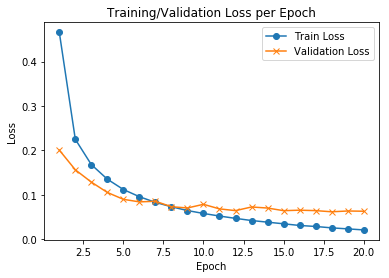

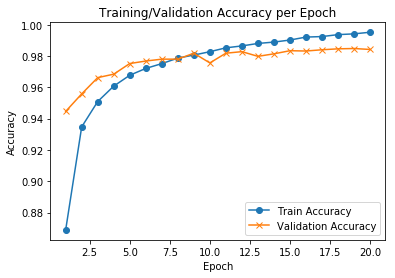

In [53]:
PlotHistory(training_history.history['loss'], training_history.history['val_loss'], 'Loss')
PlotHistory(training_history.history['acc'], training_history.history['val_acc'], 'Accuracy')

#### Regularization

In [54]:
def drawWeightHistogram(x):
    fig, ax = plt.subplots()
    n, bins, patches = plt.hist(x, 50)
    plt.xlim(-0.5, 0.5)
    plt.xlabel('Weight')
    plt.ylabel('Count')
    zero_counts = (x == 0.0).sum()
    plt.title("Weight Histogram. Num of '0's: %d" % zero_counts)

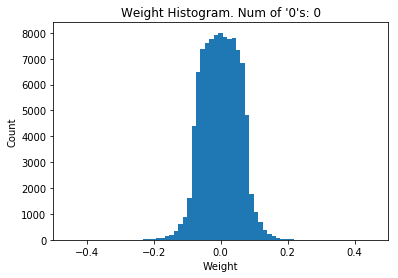

In [55]:
wl = trained_model.layers[0].get_weights()[0].flatten()
drawWeightHistogram(wl)

### 看 model 跑 test sample 的分數

In [56]:
test_score = TestModel(model=trained_model, data=[X_test, y_test])
print('Test loss {:.4f}, accuracy {:.2f}%'.format(test_score[0], test_score[1] * 100))

10000/10000 [==============================] - 0s 25us/step
Test loss 0.0754, accuracy 97.76%


### 一些畫圖的函數

In [57]:
def ShowInputImage(data):
    '''Visualize input image.'''
    plot = plt.figure()
    plot.set_size_inches(2, 2)
    plt.imshow(np.reshape(-data, (28, 28)), cmap='Greys_r')
    plt.title('Input')
    plt.axis('off')
    plt.show()

In [58]:
def ShowHiddenLayerOutput(input_data, target_layer_num):
    '''Visualize output from the target hidden layer.'''
    from keras import backend as K
    # backend converter: to TensorFlow
    target_layer = K.function(trained_model.inputs, [trained_model.layers[target_layer_num].output])
    # Extract output from the target hidden layer
    target_layer_out = target_layer([input_data])
    plot = plt.figure()
    plot.set_size_inches(2, 2)
    plt.imshow(np.reshape(-target_layer_out[0][0], (16, -1)), cmap='Greys_r')
    plt.title('Hidden layer ' + str(target_layer_num))
    plt.axis('off')
    plt.show()

In [59]:
def ShowFinalOutput(input_data):
    '''Calculate final prediction.'''
    from keras import backend as K
    # backend converter: to TensorFlow
    # Calculate final prediction
    last_layer = K.function(trained_model.inputs, [trained_model.layers[-1].output])
    last_layer_out = last_layer([input_data])
    print('Final prediction: ' + str(np.argmax(last_layer_out[0][0])))

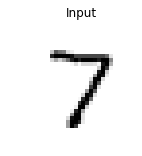

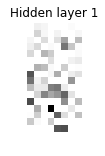

Final prediction: 7


In [60]:
ShowInputImage(X_test[0])
ShowHiddenLayerOutput(X_test, 1)
ShowFinalOutput(X_test)

In [61]:
import tensorflow as tf
print(tf.__version__)

1.12.0


***
***
***

## LSTM

### Text generation

* 用尼采的文章來產生像是尼采寫的文章
  * 如果是要用其他的輸入，那 corpus 至少要 ~100k，但最好是 ~1M
* 至少要 20 個 epochs 才能訓練出比較像樣的文章
* 需要用 GPU 加速

In [36]:
from __future__ import print_function # must occur at the beginning of the file

import numpy as np
import random
import sys

In [37]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.optimizers import SGD
from keras.utils.data_utils import get_file

* `read(size)`: size is an optional numeric argument and this func returns a quantity of data equal to size. If size if omitted, then it reads the entire file and returns it
* `readline()`: reads a single line from file with newline at the end
* `readlines()`: returns a list containing all the lines in the file
* `xreadlines()`: Returns a generator to loop over every single line in the file

In [38]:
path = get_file('nietzsche.txt', origin="https://s3.amazonaws.com/text-datasets/nietzsche.txt")

corpus = None
with open(path) as f:
    corpus = f.read() # read entire file
    corpus = corpus.lower() # change all characters to lower case

# 也可以用一行解決
# corpus = open(path).read().lower()
    
print('corpus length=', len(corpus))

corpus length= 600893


corpus 是一個字串，儲存了整篇文章的內容

In [39]:
print(type(corpus))
print(corpus[:100]) # 顯示前 100 個字元

<class 'str'>
preface


supposing that truth is a woman--what then? is there not ground
for suspecting that all ph


找出所有獨立的字元 (不是找單字)

In [40]:
chars = sorted(list(set(corpus)))

print(chars)
print('tital chars=', len(chars))

['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ä', 'æ', 'é', 'ë']
tital chars= 57


把 index 和 char 的 mapping 做成 dictionary

In [41]:
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

In [42]:
maxlen = 40
step = 3
sentences = []
next_chars = []

for i in range(0, len(corpus) - maxlen, step):
    sentences.append(corpus[i:i + maxlen])
    next_chars.append(corpus[i + maxlen]) # 因為要由前面的內容來預測下一個字元，所以要先把下一個字元找出來
print('Number of sentences=', len(sentences))

print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
        y[i, char_indices[next_chars[i]]] = 1

Number of sentences= 200285
Vectorization...


### Build LSTM model

In [43]:
# 只建立一個 LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(64, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

optimizer = SGD(lr=1)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Build model...


In [44]:
def sample(preds, temperature=1.0):
    '''
    Helper function to sample an index for a probability array
    '''
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

訓練模型，每個 iteration 結束就把產生的字輸出

In [70]:
for iteration in range(1, 20):
    print()
    print('-'*50)
    print('Iteration', iteration)
    model.fit(X, y, batch_size=128, epochs=1)
    
    start_index = np.random.randint(0, len(corpus) - maxlen - 1)
    
#     for diversity in [0.2, 0.5, 1.0, 1.2]:
    for diversity in [0.5]:
        print()
        print('----- diversity = ', diversity)
        
        generated = ''
        sentence = corpus[start_index : start_index + maxlen]
        generated += sentence
        print('Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)
        
        for i in range(200):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                X[0, t, char_indices[char]] = 1.
                
            preds = model.predict(X, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]
            
            generated += next_char
            sentence = sentence[1:] + next_char
            
            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()


--------------------------------------------------
Iteration 1
Epoch 1/1
200285/200285 [==============================] - 195s 974us/step - loss: 2.5128

----- diversity =  0.5
Generating with seed: "negation and not in revenge the element
"
negation and not in revenge the element
rntgaeggdy sddsddastddd

KeyboardInterrupt: 

***
***
***

## LSTM

## Twiter

In [ ]:
from __future__ import print_function

import csv
import numpy as np
import operator
import re

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils import to_categorical

In [ ]:
max_vocabulary = 10000
maxlen = 20
batch_size = 256

In [ ]:
def preprocess_words(words):
    # Remove consecutive period symbols
    words = re.sub(r"[\. ][\. ]+", " . ", words)
    # Replace word+comma with word [space] comma
    words = re.sub(r",", " , ", words)
    # Replace word+parenthesis with word [space] parenthesis.
    # E.g., this(is) -> this ( is )
    words = re.sub(r"[\(\)]", " \l ", words)
    return words.split()

In [ ]:
def load_twitter(filename):
    labels = []
    tweets = []
    with open(filename) as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            # Column names = ItemID, Sentiment, SentimentSource, SentimentText
            labels.append(int(row['Sentiment']))
            words = row['SentimentText'].strip().lower()
            tweets.append(preprocess_words(words))
    return np.array(tweets), np.array(labels)

In [ ]:
print('Loading data...')
tweets, labels = load_twitter('Sentiment_Analysis_Dataset.csv')
print('Load', len(labels), 'tweets')
print('First tweet: {}'.format(' '.join(tweets[0])))
print('First tweet label: {}'.format(labels[0]))

In [ ]:
# randomize tweets and create training/test sets
np.random.seed(1337)
rand_idx = np.random.permutation(len(labels))
rand_idx[:-10000]

In [ ]:
# select last 10000 tweets as test set
tweets_training = tweets[rand_idx[:-10000]]
labels_training = labels[rand_idx[:-10000]]

tweets_test = tweets[rand_idx[-10000:]]
labels_test = labels[rand_idx[-10000:]]

In [ ]:
def build_vocabulary(tweets):
    print('### Example tweets:')
    print(' '.join(tweets[0]))
    print(' '.join(tweets[1]))
    vocab = dict()
    for t in tweets:
        for word in t:
            if word.startswith('@'): # ignore twitter username
                continue
            if word not in vocab:
                vocab[word] = 0
            vocab[word] += 1
    # sort vocabulary by count
    vocab = sorted(vocab.items(), key=operator.itemgetter(1), reverse=True)
    # keep only top max_vocabulary ones
    vocab = vocab[:max_vocabulary - 1] # max_vocabulary - 1: reserve one spot for 'unknown' token.
    vocab.append(('<unk>', 0))
    print('### Top 5 vocabs after sorting:')
    print(vocab[:5])
    return vocab

In [ ]:
vocabulary = build_vocabulary(tweets_training)

In [ ]:
def save_vocab(vocabulary):
    with open('vocab.txt', 'w') as vf:
        for v in vocabulary:
            vf.write(v[0])
            vf.write('\t')
            vf.write(str(v[1]))
            vf.write('\n')

In [ ]:
save_vocab(vocabulary)

In [ ]:
def create_vocab_index(vocab):
    vocab_idx = dict()
    v_id = 0
    for v in vocab:
        vocab_idx[v[0]] = v_id
        v_id += 1
    return vocab_idx

In [ ]:
vocab_word_to_id = create_vocab_index(vocabulary)
vocab_id_to_word = [(idx, word) for (word, idx) in vocab_word_to_id.items()]

In [ ]:
def transcode_words(sents, vocab_index):
    coded_words = [[vocab_index[w] if w in vocab_index else vocab_index['<unk>'] for w in words for words in sents]]
    return coded_words

In [ ]:
tweets_training_to_id = transcode_words(tweets_training, vocab_word_to_id)
tweets_test_to_id = transcode_words(tweets_test, vocab_word_to_id)

In [ ]:
# must transcode from word to word_id first!!
print('Pad sequences (samples x time)')
tweets_training_to_id_padded = sequence.pad_sequences(tweets_training_to_id, maxlen=maxlen)
tweets_test_to_id_padded = sequence.pad_sequences(tweets_test_to_id, maxlen=maxlen)
print('features shape:', tweets_training_to_padded.shape)

In [ ]:
# turn label to one-hot
labels_training_onehot = to_categorical(labels_training, num_classes=2)
labels_test_onehot = to_categorical(labels_test, num_classes=2)

In [ ]:
def build_model():
    print('Building model...')
    model = Sequential()
    model.add(Embedding(max_vocabulary, 300))
    model.add(LSTM(16, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(2, activation='sigmoid'))
    
    # try using different optimizers and different optimizer configs
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [ ]:
def train(model):
    print('Train...')
    model.fit(tweets_training_to_id_padded, labels_training_outhot,
              batch_size=batch_size,
              epochs=10,
              validation_data=(tweets_test_to_id_padded, labels_test_onehot))
    score, acc = model.evaluate(tweets_test_to_id_padded, labels_test_onehot, batch_size=batch_size)
    print('Test score:' score)
    print('Test accuracy:' acc)

In [ ]:
tweet_classify_model = build_model()
train(tweet_classify_model)
tweet_classify_model.save('tweet_model.pkl')

In [ ]:
import tensorflow as tf
print(tf.__version__)

from keras.models import load_model
pre_trained_model = load_model('tweet_model.pkl')
pre_trained_model.summary()

***
***
***

## CNN

In [71]:
from __future__ import print_function

import keras.callbacks as cb
from keras.datasets import mnist
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.models import Sequential
from keras.optimizers import SGD
from keras.regularizers import l1, l2
from keras.utils import np_utils

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import time

### 1. Preprocessing

* 要先把 image data 轉成 3D tensor
  * 維度是 width x height x channel
  * channel 就是指顏色
* Data augmentation
  * Cropping
  * Random cropping
  * Rotation
  * Add random noises

In [75]:
def PreprocessDataset():
    # Load dataset
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    # Set numeric type
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    # Normalize value to [0, 1]
    X_train /= 255
    X_test /= 255
    # Transform labels to one-hot
    y_train = np_utils.to_categorical(y_train, 10)
    y_test = np_utils.to_categorical(y_test, 10)
    # Reshape: here X_train is reshaped to [channel] x [width] x [height]
    # In other environment, the orders could be different; e.g., [height] x [width] x [channel].
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
    return [X_train, X_test, y_train, y_test]

In [76]:
X_train, X_test, y_train, y_test = PreprocessDataset()

### 2. 定義 model

定義一個 CNN model 需要設定
1. **Filter**: filter 的大小，有幾個 filters？
2. **Depth**: 有幾層？通常是 10 ~ 30 層
3. **Stride**: filter 一次移動多少格？
4. **Padding**: 要不要在最外圍加上一圈都是 0 的?

### Pooling

In [77]:
num_filters = 16 # 建立 16 個 filters
filter_size = 3 # filter 的大小是 3x3

In [78]:
def DefineModel():
    model = Sequential()
    # First conv layer with filters of 3x3 pixels; also need to specify input shape.
    # The number of filters is set to 16 for shorter runtime
    # Increase the number of filters for better accuracy.
    # Strides are defined as in subsample=(1, 1)
    model.add(Conv2D(num_filters, (filter_size, filter_size), input_shape=(28, 28, 1), padding='valid'))
    # The activation for first layer is ReLU
    model.add(Activation('relu'))
    # Max pooling
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # The last layer has the same dimension as the number of classes
    model.add(Flatten())
    model.add(Dense(10))
    # For classification, the activation is softmax
    model.add(Activation('softmax'))
    # Define optimizer
    optmzr = SGD(lr=0.1, clipnorm=5.)
    # Define loss function = cross entropy
    model.compile(loss='categorical_crossentropy', optimizer=optmzr, metrics=['accuracy'])
    
    return model

### 3. 定義怎麼 train model

In [79]:
def TrainModel(data=None, epochs=20, batch=256):
    start_time = time.time()
    model = DefineModel()
    if data is None:
        print('Must provide data.')
        return
    X_train, X_test, y_train, y_test = data
    print('Start training...')
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch,
                        validation_data=(X_test, y_test), verbose=1)
    print('Training took {0} seconds.'.format(time.time() - start_time))
    return model, history

### 4. 定義怎麼 test model

In [80]:
def TestModel(model=None, data=None):
    if model is None:
        print('Must provide a trained model.')
        return
    if data is None:
        print('Must provide data.')
        return
    X_test, y_test = data
    scores = model.evaluate(X_test, y_test)
    return scores

### 5. 開始訓練

In [81]:
trained_model, training_historhy = TrainModel(data=[X_train, X_test, y_train, y_test])

Start training...
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 7s 116us/step - loss: 0.5820 - acc: 0.8275 - val_loss: 0.3372 - val_acc: 0.9011
Epoch 2/20
60000/60000 [==============================] - 6s 101us/step - loss: 0.3202 - acc: 0.9053 - val_loss: 0.2691 - val_acc: 0.9208
Epoch 3/20
60000/60000 [==============================] - 6s 100us/step - loss: 0.2690 - acc: 0.9223 - val_loss: 0.2757 - val_acc: 0.9183
Epoch 4/20
60000/60000 [==============================] - 6s 107us/step - loss: 0.2211 - acc: 0.9372 - val_loss: 0.2551 - val_acc: 0.9225
Epoch 5/20
60000/60000 [==============================] - 6s 108us/step - loss: 0.1813 - acc: 0.9491 - val_loss: 0.1628 - val_acc: 0.9546
Epoch 6/20
60000/60000 [==============================] - 6s 105us/step - loss: 0.1522 - acc: 0.9581 - val_loss: 0.1363 - val_acc: 0.9622
Epoch 7/20
60000/60000 [==============================] - 6s 97us/step - loss: 0.1307 - acc: 0.9642 - va

### 6. 畫圖看節果

#### Loss 和 accuracy 的圖

In [82]:
def PlotHistory(train_value, test_value, value_is_loss_or_acc):
    fig, ax = plt.subplots()
    ax.plot([None] + train_value, 'o-')
    ax.plot([None] + test_value, 'x-')
    # Plot legend and use the best location automatically: loc = 0.
    ax.legend(['Train ' + value_is_loss_or_acc, 'Validation ' + value_is_loss_or_acc], loc=0)
    ax.set_title('Training/Validation ' + value_is_loss_or_acc + ' per Epoch')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(value_is_loss_or_acc)

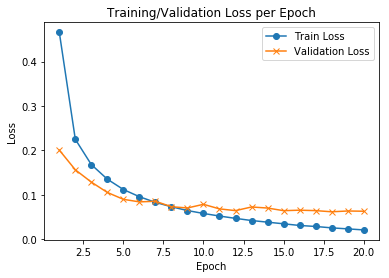

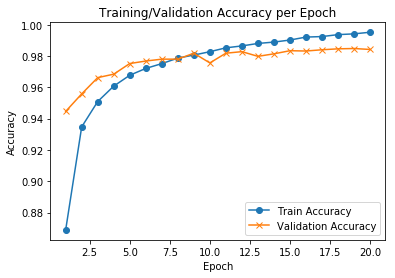

In [83]:
PlotHistory(training_history.history['loss'], training_history.history['val_loss'], 'Loss')
PlotHistory(training_history.history['acc'], training_history.history['val_acc'], 'Accuracy')

### 7. 看訓練好的 model 跑 test sample 的分數

In [84]:
test_score = TestModel(model=trained_model, data=[X_test, y_test])
print('Test loss {:.4f}, accuracy {:.2f}%'.format(test_score[0], test_score[1] * 100))

10000/10000 [==============================] - 0s 47us/step
Test loss 0.0644, accuracy 97.93%


### 8. 定義一些畫圖的函數

用來看 convolutional layers

In [90]:
def ShowConvolutionOutput(input_data, show_pic_idx):
    from keras import backend as K
    first_conv = K.function(trained_model.inputs, [trained_model.layers[1].output])
    first_conv_out = first_conv([input_data])
    fig, axes = plt.subplots(num_filters // 4, 4, figsize=(8, 8))
    for filter_num in range(num_filters):
        fig_x, fig_y = divmod(filter_num, 4)
        if fig_y == 0:
            fig_x -= 1
        axes[fig_x][fig_y].imshow(first_conv_out[0][show_pic_idx][filter_num])
        plt.setp(axes[fig_x][fig_y].get_xticklabels(), visible=False)
        plt.setp(axes[fig_x][fig_y].get_yticklabels(), visible=False)
    fig.tight_layout(pad=0)
    plt.show()

In [91]:
def ShowInputImage(data):
    plot = plt.figure()
    plot.set_size_inches(2, 2)
    plt.imshow(np.reshape(-data, (28, 28)), cmap='Greys_r')
    plt.title('Input')
    plt.axis('off')
    plt.show()

In [92]:
def ShowFinalOutput(input_data, samp):
    '''Calculate final prediction.'''
    from keras import backend as K
    # Calculate final prediction.
    last_layer = K.function(trained_model.inputs, [trained_model.layers[-1].output])
    last_layer_out = last_layer([input_data])
    print('Final prediction: ' + str(np.argmax(last_layer_out[0][samp])))

### Show random test data

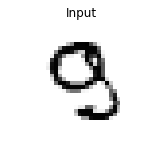

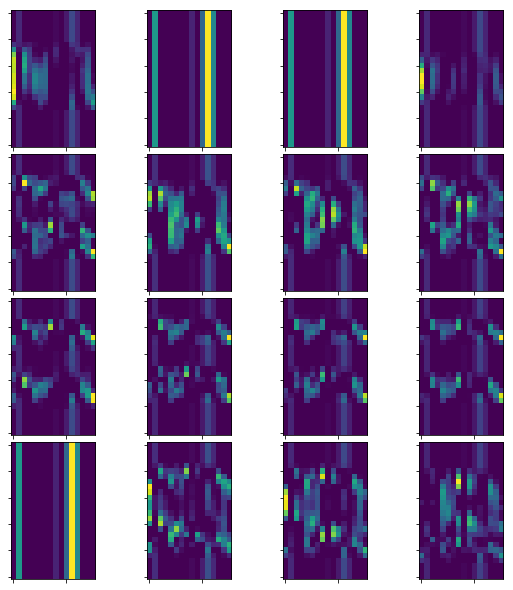

Final prediction: 9


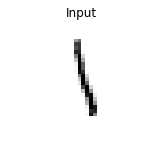

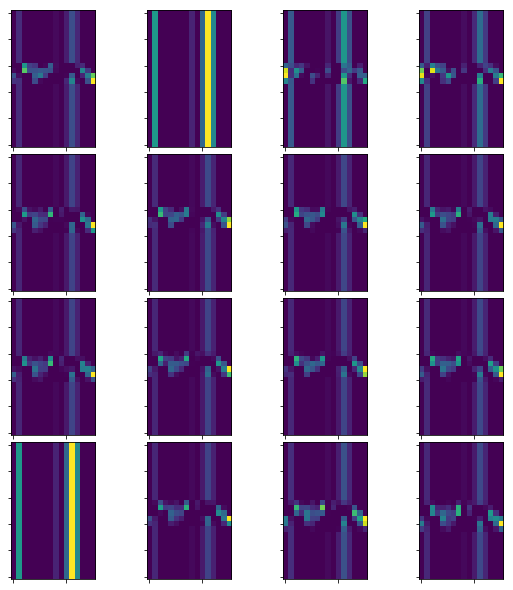

Final prediction: 1


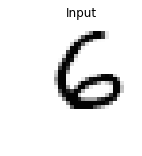

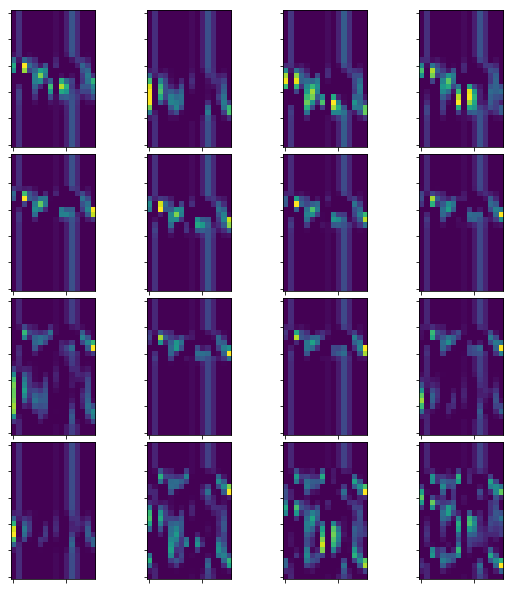

Final prediction: 6


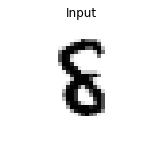

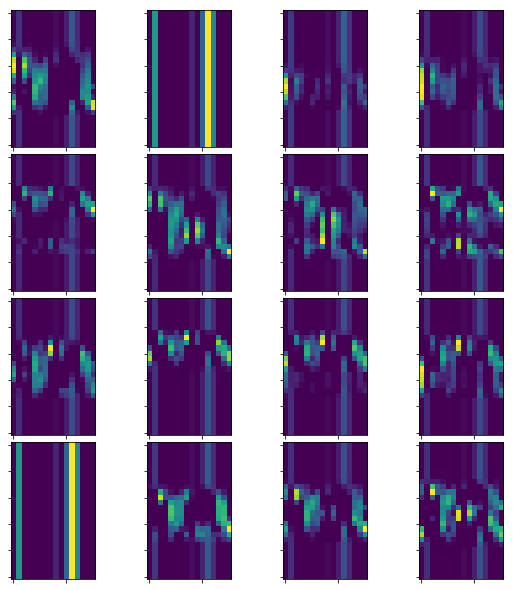

Final prediction: 8


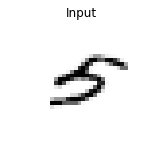

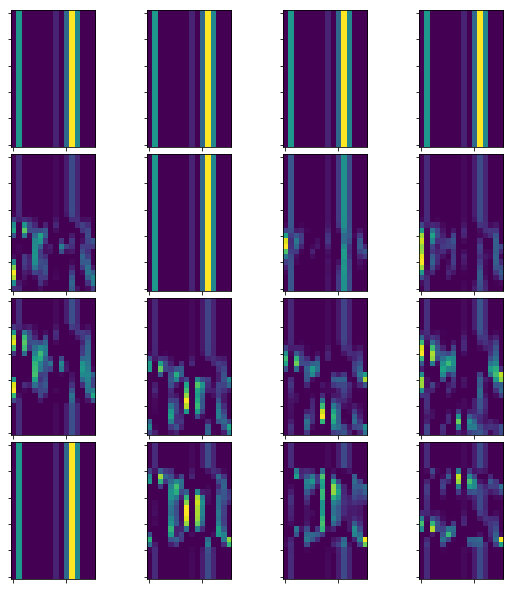

Final prediction: 5


In [93]:
np.random.seed(1337)
show_which_ones = np.random.randint(0, 999, 5)
for samp in show_which_ones:
    ShowInputImage(X_test[samp])
    ShowConvolutionOutput(X_test, samp)
    ShowFinalOutput(X_test, samp)

***
***
***

# Tensorflow

## Devise

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

### Load data

In [3]:
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

### Define parameters

In [4]:
# Training-related hyper-parameters
LEARNING_RATE = 0.001
MAX_TRAIN_EPOCHS = 1000
BATCH_SIZE = 128
display_step = 10

# Network parameters
INPUT_DIM = 784 # MNIST data input (img shape: 28x28)
NUM_CLASSES = 10 # MINST total classes (0-9 digits)
DROPOUT_KEEP_RATE = 0.75 # Dropout keep rate

### Define tensorflow graph

In [5]:
x = tf.placeholder(tf.float32, [None, INPUT_DIM])
y = tf.placeholder(tf.float32, [None, NUM_CLASSES])
keep_prob = tf.placeholder(tf.float32) # Dropout keep rate

In [12]:
def ConvTwoD(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

In [13]:
def MaxpoolTwoD(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

### Create CNN model

In [17]:
def ConvNet(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 28, 28, 1])
    
    # Convolution Layer
    conv1 = ConvTwoD(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = MaxpoolTwoD(conv1, k=2)
    
    # Convolution Layer
    conv2 = ConvTwoD(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = MaxpoolTwoD(conv2, k=2)
    
    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)
    
    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

### Dictionaries to store layers weight & bias

In [18]:
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected 7x7x64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, NUM_CLASSES]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([NUM_CLASSES]))
}

### Construct model

In [19]:
pred = ConvNet(x, weights, biases, keep_prob)

# Define loss and optimizer
print('oringinal y')
print(y)

print('ext_y')
ext_y = tf.reshape(y, [-1, 1, NUM_CLASSES])
ext_y = tf.tile(ext_y, [1, NUM_CLASSES, 1])
print(ext_y)

print('original pred')
print(pred)

print('ext_pred')
ext_pred = tf.reshape(pred, [-1, 1, NUM_CLASSES])
ext_pred = tf.tile(ext_pred, [1, NUM_CLASSES, 1])
print(ext_pred)

print('other_class')
other_class = tf.eye(NUM_CLASSES)
other_class = tf.reshape(other_class, [-1, NUM_CLASSES, NUM_CLASSES])
other_class = tf.tile(other_class, [BATCH_SIZE, 1, 1])
print(other_class)

print('tmp_sum')
tmp_sum = tf.reduce_sum((ext_y - other_class) * ext_pred, axis=2)
print(tmp_sum)

print('max_margin_loss')
max_margin_loss = tf.maximum(0.0, 0.1 - tmp_sum)
max_margin_loss = tf.reduce_sum(max_margin_loss)
print(max_margin_loss)

cost = max_margin_loss

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

oringinal y
Tensor("Placeholder_1:0", shape=(?, 10), dtype=float32)
ext_y
Tensor("Tile:0", shape=(?, 10, 10), dtype=float32)
original pred
Tensor("Add_2:0", shape=(?, 10), dtype=float32)
ext_pred
Tensor("Tile_1:0", shape=(?, 10, 10), dtype=float32)
other_class
Tensor("Tile_2:0", shape=(128, 10, 10), dtype=float32)
tmp_sum
Tensor("Sum:0", shape=(128, 10), dtype=float32)
max_margin_loss
Tensor("Sum_1:0", shape=(), dtype=float32)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



### Launch the graph

In [22]:
with tf.Session() as sess:
    sess.run(init)
    step = 1
    
    # Keep training until reach max iterations
    while step < MAX_TRAIN_EPOCHS:
        batch_x, batch_y = mnist.train.next_batch(BATCH_SIZE)
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: DROPOUT_KEEP_RATE})
    
        if step % display_step == 0:
            # Evaluate batch loss and accuracy
            loss, acc = sess.run([cost, accuracy], feed_dict = {x: batch_x, y: batch_y, keep_prob: 1.})
            print('Iter ' + str(step) + \
                  ', Minibatch Loss = {:.6f}'.format(loss) + \
                  ', Training Accuracy = {:.5f}'.format(acc))
        step += 1
    print('Optimization Done.')
    
    # Calculate accuracy for 256 mnist test images
    print('Testing Accuracy:', \
          sess.run(accuracy, feed_dict={x: mnist.test.images[:256],
                                        y: mnist.test.labels[:256],
                                        keep_prob: 1.}))

Iter 10, Minibatch Loss = 21462.496094, Training Accuracy = 0.26562
Iter 20, Minibatch Loss = 8527.250977, Training Accuracy = 0.63281
Iter 30, Minibatch Loss = 5054.499023, Training Accuracy = 0.70312
Iter 40, Minibatch Loss = 5272.771484, Training Accuracy = 0.75000
Iter 50, Minibatch Loss = 3629.965820, Training Accuracy = 0.81250
Iter 60, Minibatch Loss = 4020.753906, Training Accuracy = 0.82031
Iter 70, Minibatch Loss = 3740.307129, Training Accuracy = 0.85938
Iter 80, Minibatch Loss = 2655.160156, Training Accuracy = 0.87500
Iter 90, Minibatch Loss = 1376.174316, Training Accuracy = 0.91406
Iter 100, Minibatch Loss = 1981.338989, Training Accuracy = 0.85938
Iter 110, Minibatch Loss = 1692.707520, Training Accuracy = 0.89844
Iter 120, Minibatch Loss = 2302.068848, Training Accuracy = 0.91406
Iter 130, Minibatch Loss = 1843.704834, Training Accuracy = 0.89844
Iter 140, Minibatch Loss = 1913.491455, Training Accuracy = 0.89844
Iter 150, Minibatch Loss = 2435.769531, Training Accurac

AttributeError: 'Datasets' object has no attribute 'test_images'

***
***
***